<a href="https://colab.research.google.com/github/musab-r/Computational_Intelligence_Project/blob/main/Phase%204%20HNGFS/Optimization_HNFG_IMDB_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Computational Intelligence Project: Sentiment Analysis on IMDB dataset Using HNGFS

Musab - 19030008

In this Notebook, I have done implementing Hybrid Neuro Genetic Fuzzy System.  In this second approach, an optimization is applied to Neuro-fuzzy inference system using genetic algorithm. Neuro-fuzzy is also called ANFIS. Genetic Algorithm is used to optimize the hybrid model using different weights of the network.

In [ ]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.datasets import mnist, imdb
import numpy as np
from keras import regularizers
import matplotlib.pyplot as plt
from FuzzyLayer import FuzzyLayer
from tensorflow.python.client import device_lib
from keras.utils import to_categorical
import re
import keras
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix



In [ ]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=5000)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
print("train_data ", x_train.shape)
print("train_labels ", y_train.shape)
print("_"*100)
print("test_data ", x_test.shape)
print("test_labels ", y_test.shape)
print("_"*100)
print("Maximum value of a word index ")
print(max([max(sequence) for sequence in x_train]))
print("Maximum length num words of review in train ")
print(max([len(sequence) for sequence in x_train]))

train_data  (25000,)
train_labels  (25000,)
____________________________________________________________________________________________________
test_data  (25000,)
test_labels  (25000,)
____________________________________________________________________________________________________
Maximum value of a word index 
4999
Maximum length num words of review in train 
2494


In [ ]:
x_train = x_train[:10000] 
y_train = y_train[:10000] 
print(x_train.shape)

x_test = x_test[:10000] 
y_test = y_test[:10000] 
print(x_test.shape)

(10000,)
(10000,)


In [ ]:
def vectorize_sequences(sequences, dimension=5000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

In [ ]:
x_train = vectorize_sequences(x_train)
x_test = vectorize_sequences(x_test)

print("x_train ", x_train.shape)
print("x_test ", x_test.shape)

x_train  (10000, 5000)
x_test  (10000, 5000)


In [ ]:
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')
print("y_train ", y_train.shape)
print("y_test ", y_test.shape)

y_train  (10000,)
y_test  (10000,)


In [ ]:
x_val = x_train[:2000]
partial_x_train = x_train[2000:]
y_val = y_train[:2000]
partial_y_train = y_train[2000:]

print("x_val ", x_val.shape)
print("partial_x_train ", partial_x_train.shape)
print("y_val ", y_val.shape)
print("partial_y_train ", partial_y_train.shape)

x_val  (2000, 5000)
partial_x_train  (8000, 5000)
y_val  (2000,)
partial_y_train  (8000,)


### ANFIS Network Ensemble with Genetic Algo

In [ ]:
class FuzzyLayer(Layer):

    def __init__(self, 
                 output_dim, 
                 initializer_centers=None,
                 initializer_sigmas=None, 
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        self.output_dim = output_dim
        self.initializer_centers = initializer_centers
        self.initializer_sigmas = initializer_sigmas
        super(FuzzyLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.input_dimensions = list(input_shape)[:-1:-1]
        self.c = self.add_weight(name='c', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer= self.initializer_centers if self.initializer_centers is not None else 'uniform',
                                 trainable=True)
        self.a = self.add_weight(name='a', 
                                 shape=(input_shape[-1], self.output_dim),
                                 initializer=self.initializer_sigmas if self.initializer_sigmas is not None else 'ones',
                                 trainable=True)
        super(FuzzyLayer, self).build(input_shape)  

    def call(self, x):
        
        aligned_x = K.repeat_elements(K.expand_dims(x, axis = -1), self.output_dim, -1)
        aligned_c = self.c
        aligned_a = self.a
        for dim in self.input_dimensions:
            aligned_c = K.repeat_elements(K.expand_dims(aligned_c, 0), dim, 0)
            aligned_a = K.repeat_elements(K.expand_dims(aligned_a, 0), dim, 0)

        xc = K.exp(-K.sum(K.square((aligned_x - aligned_c) / (2 * aligned_a)), axis=-2, keepdims=False))
        #sums = K.sum(xc,axis=-1,keepdims=True)
        #less = K.ones_like(sums) * K.epsilon()
        return xc# xc / K.maximum(sums, less)
        
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[:-1]) + (self.output_dim,)

In [ ]:
class Network:
    def __init__(self):

        input_img = Input(shape=(5000,))

        model = Dense(256, kernel_regularizer=regularizers.l1(0.0001), activation='relu')(input_img)
        model = Dense(2,activation='relu')(model)
        f_layer = FuzzyLayer(100)
        model = f_layer(model)
        model = Dense(1, activation='linear')(model)
        model = Model(input_img, model)

        model.compile(optimizer='sgd', loss='mse',metrics=['acc'])
        self.model = model
        self.acc_history = []
    
    def return_acc_history(self):
        return self.acc_history
    
    def get_layer_weight(self,i):
        return self.model.layers[i].get_weights()
    
    def set_layer_weight(self,i,weight):
        self.model.layers[i].set_weights(weight)
        
    def train(self):
        # self.model.fit(X_train,y_train, batch_size = 32, epochs = 1, verbose = 1,shuffle = True) #, validation_data =(X_test, y_test)
        self.model.fit(x_train, y_train,
                epochs=1,
                verbose = 1,
                batch_size=32,
                shuffle=True,
                validation_data=(x_val, y_val))
    
    def test(self):
        loss, acc = self.model.evaluate(x_test,y_test)
        self.acc_history.append(acc)

        prediction = self.model.predict(x_test)
        y_pred = (prediction > 0.5)
        print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
        print('Confusion matrix:', confusion_matrix(y_pred, y_test))
        return acc
    
    def load_layer_weights(self,weights):
        self.model.set_weights(weights) 
    
    def give_weights(self):
        return self.model.get_weights()
    def weight_len(self):
        i = 0 
        for j in self.model.layers:
            i+=1
        return i 
    def architecture(self):
        self.model.summary()

In [ ]:
 class GeneticAlgorithm:
    def __init__(self, population_size, mutation_rate, generations = 50):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.generations = generations
        self.population = None
        self.children_population_weights = []
        self.acces = []
        self.norm_acces = []
        
    def create_population(self):
        self.population = [Network() for i in range(self.population_size)]
    
    def train_generation(self):
        for member in self.population:
                member.train()
                
    def predict(self):
        for member in self.population:
                acc = member.test()
                self.acc.append(acc)
    
    def normalize(self):
        sum_ = sum(self.acc)
        self.norm_acc = [i/sum_ for i in self.acc] 
        print("\nNormalization sum: ",sum(self.norm_acc))
        #assert sum(self.norm_acc) == 1
        
    def show_weights(self):
        for i in parent_weights:
            print(i)
    def clear_losses(self):
        self.norm_acc = []
        self.acc = []
        
    def mutate(self):
        for member in self.population:
            for i in range(member.weight_len()):
                if np.random.random() < self.mutation_rate:
                    print("\Mutation at ", self.mutation_rate)
                    old_weight = member.get_layer_weight(i)
                    new_weight = [np.random.uniform(low=-1, high=1, size=old_weight[i].shape) for i in range(len(old_weight))]
                    member.set_layer_weight(i, new_weight)
    
    def reproduction(self):
        """ 
        Reproduction through midpoint crossover method 
        """
        population_idx = [i for i in range(len(self.population))]
        for i in range(len(self.population)):
        #selects two parents probabilistic accroding to the fitness
            # print("Crossover | Choosing Best Parent on the bases of fitness probbaility\n")
            if sum(self.norm_acc) != 0:
                parent1 = np.random.choice(population_idx, p = self.norm_acc)
                parent2 = np.random.choice(population_idx, p = self.norm_acc)
            else:
              # if there are no "best" parents choose randomly 
                parent1 = np.random.choice(population_idx)
                parent2 = np.random.choice(population_idx)

            # picking random midpoint for crossing over name/DNA
            parent1_weights = self.population[parent1].give_weights()
            parent2_weights = self.population[parent2].give_weights()
            
            
            mid_point = np.random.choice([i for i in range(len(parent1_weights))])
            # adding DNA-Sequences of the parents to final DNA
            self.children_population_weights.append(parent1_weights[:mid_point] + parent2_weights[mid_point:])
        # old population gets the new and proper weights
        for i in range(len(self.population)):
            for j in range(len(self.children_population_weights)):
                self.population[i].load_layer_weights(self.children_population_weights[j])
        
    def run_evolution(self):
        for episode in range(self.generations):
            self.clear_losses()
            self.train_generation()
            self.predict()
            if episode != self.generations -1:
                self.normalize()
                self.reproduction()
                self.mutate()
            else:
                pass
        
        # plotting history:
        for a in range(self.generations):
            for member in self.population:
                plt.plot(member.acc_history)
        plt.xlabel("No. of Generations")
        plt.ylabel("Model Accuracy")
        plt.show()

313/313 [==============================] - 1s 3ms/step - loss: 2.3343 - acc: 0.6682
F1-score: 0.6894421564956945
Confusion matrix: [[2999 1290]
 [2028 3683]]
313/313 [==============================] - 1s 3ms/step - loss: 2.3789 - acc: 0.5538
F1-score: 0.6708468574800827
Confusion matrix: [[ 991  426]
 [4036 4547]]
313/313 [==============================] - 1s 3ms/step - loss: 2.3434 - acc: 0.6468
F1-score: 0.6909345467273363
Confusion matrix: [[2520 1025]
 [2507 3948]]
313/313 [==============================] - 1s 3ms/step - loss: 2.3484 - acc: 0.6286
F1-score: 0.5314155942467828
Confusion matrix: [[4180 2867]
 [ 847 2106]]

Normalization sum:  1.0
\Mutation at  0.05
\Mutation at  0.05
313/313 [==============================] - 1s 3ms/step - loss: 2.3333 - acc: 0.5045
F1-score: 0.02976307029567261
Confusion matrix: [[4969 4897]
 [  58   76]]
313/313 [==============================] - 1s 3ms/step - loss: 2.2345 - acc: 0.7868
F1-score: 0.7849939491730538
Confusion matrix: [[3976 1081]
 [

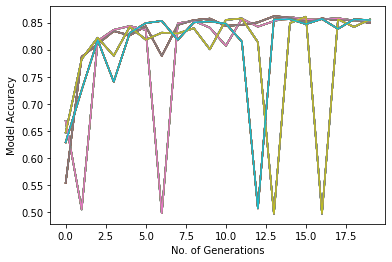

In [ ]:
GA = GeneticAlgorithm(population_size = 4,mutation_rate = 0.05, generations = 20)
GA.create_population()
GA.run_evolution()

In [1]:
import os
os.chdir('/content/drive/My Drive/')
!pwd

/content/drive/My Drive
